# (0) Driveのマウント と Signate API

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
# Signate APIでデータ取得
!pip install signate
!signate files --competition-id=1523
!signate download --competition-id=1523

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=b697e27a7a7fd60d4715fc3f5dd03df890f8cf1ae765b6cf7944e2d28b904e21
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00
sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


# (1) 外部ライブラリのインストール

In [4]:
# 前処理、モデルに必要
!pip install kanjize
!pip install optuna
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [5]:
# EDAレポート作成時に使用
# !pip install pandas_profiling
# !pip install numba
# !pip install ydata-profiling
# !pip install pandas-profiling
# !pip install dtale
# !pip install sweetviz
# !pip install numpy==1.23.1

# (2) 前処理

In [6]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [7]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1")

# Ageの処理
for i in range(len(all_df)):
# for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10代は19歳にする
    if(-1<tmp & tmp<20):
      all_df.loc[i,"Age"] = 19
    elif(tmp>60):
      all_df.loc[i,"Age"] = 61
    else:
      # 10歳で分けて5足す
      tmp = tmp//10 * 10
      all_df.loc[i,"Age"] = tmp + 5

# int型に変換
all_df["Age"] = all_df["Age"].astype(int)

print(all_df.groupby("Age").size())

Age
-1     193
 18     17
 19     28
 20     47
 21     58
 22     81
 23     74
 24     96
 25    193
 26    123
 27    122
 28    160
 29    158
 30    194
 31    217
 32    234
 33    263
 34    234
 35    469
 36    257
 37    238
 38    206
 39    204
 40    188
 41    186
 42    198
 43    170
 44    129
 45    354
 46    146
 47    144
 48    125
 49    136
 50    165
 51    156
 52    154
 53    131
 54    131
 55    252
 56     97
 57     86
 58     63
 59     53
 60     30
 61     14
 65      4
dtype: int64


In [8]:
# 学生、定年を考慮
# カテゴリ列の追加
all_df["Age_cls"] = all_df["Age"].copy()

all_df.loc[all_df["Age"]<0,"Age_cls"] = "不明"
all_df.loc[(all_df["Age"]>=0) & (all_df["Age"]<=22),"Age_cls"] = "Student"
all_df.loc[(all_df["Age"]>=23) & (all_df["Age"]<=26),"Age_cls"] = "23~26years"
all_df.loc[(all_df["Age"]>=27) & (all_df["Age"]<=30),"Age_cls"] = "27~30years"
all_df.loc[(all_df["Age"]>=31) & (all_df["Age"]<=34),"Age_cls"] = "31~34years"
all_df.loc[(all_df["Age"]>=35) & (all_df["Age"]<=38),"Age_cls"] = "35~38years"
all_df.loc[(all_df["Age"]>=39) & (all_df["Age"]<=42),"Age_cls"] = "39~42years"
all_df.loc[(all_df["Age"]>=43) & (all_df["Age"]<=46),"Age_cls"] = "43~46years"
all_df.loc[(all_df["Age"]>=47) & (all_df["Age"]<=50),"Age_cls"] = "47~50years"
all_df.loc[(all_df["Age"]>=51) & (all_df["Age"]<=54),"Age_cls"] = "51~54years"
all_df.loc[(all_df["Age"]>=55) & (all_df["Age"]<=58),"Age_cls"] = "55~58years"
all_df.loc[all_df["Age"]>=59,"Age_cls"] = "Retire"

# 元のカラムを削除する
all_df = all_df.drop("Age",axis=1)

all_df['Age_cls'] = all_df['Age_cls'].astype('object')
print(all_df.groupby(["Age_cls"]).size())

Age_cls
23~26years     486
27~30years     634
31~34years     948
35~38years    1170
39~42years     776
43~46years     799
47~50years     570
51~54years     572
55~58years     498
Retire         101
Student        231
不明             193
dtype: int64


<ipython-input-8-1977435000>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["Age"]<0,"Age_cls"] = "不明"


In [9]:
# # カテゴリ列の追加
# all_df["Age_cls"] = all_df["Age"].copy()

# all_df.loc[all_df["Age"]<0,"Age_cls"] = "NA"
# all_df.loc[(all_df["Age"]>=10) & (all_df["Age"]<=20),"Age_cls"] = "~20years"
# all_df.loc[(all_df["Age"]>=21) & (all_df["Age"]<=25),"Age_cls"] = "21~25years"
# all_df.loc[(all_df["Age"]>=26) & (all_df["Age"]<=30),"Age_cls"] = "26~30years"
# all_df.loc[(all_df["Age"]>=31) & (all_df["Age"]<=35),"Age_cls"] = "31~35years"
# all_df.loc[(all_df["Age"]>=36) & (all_df["Age"]<=40),"Age_cls"] = "36~40years"
# all_df.loc[(all_df["Age"]>=41) & (all_df["Age"]<=45),"Age_cls"] = "41~45years"
# all_df.loc[(all_df["Age"]>=46) & (all_df["Age"]<=50),"Age_cls"] = "46~50years"
# all_df.loc[(all_df["Age"]>=51) & (all_df["Age"]<=55),"Age_cls"] = "51~55years"
# all_df.loc[all_df["Age"]>=56,"Age_cls"] = "56years~"

# # 元のカラムを削除する
# # all_df = all_df.drop("Age",axis=1)

# all_df['Age_cls'] = all_df['Age_cls'].astype('object')
# print(all_df.groupby(["Age_cls"]).size())

In [10]:
#########################
# "TypeofContact"の処理 #
#########################
print(all_df.groupby("TypeofContact").size())

TypeofContact
Company Invited    2516
Self Enquiry       4444
dtype: int64


In [11]:
#########################
# "CityTier"の処理 #
#########################
all_df["CityTier"] = all_df["CityTier"].astype("object")
print(all_df.groupby("CityTier").size())

CityTier
1    2991
2    3160
3     827
dtype: int64


In [12]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(len(all_df)):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

# int型に変換
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("int")

# 秒に換算
all_df["DurationOfPitch"] = all_df["DurationOfPitch"] * 60
print(all_df.groupby("DurationOfPitch").size())

DurationOfPitch
-60      252
 240       3
 300      43
 360     167
 420     446
 480     671
 540     654
 600     467
 660     306
 720     293
 780     397
 840     518
 900     569
 960     527
 1020    312
 1080    133
 1140     50
 1200     66
 1260     65
 1320     84
 1380    104
 1440     86
 1500     79
 1560     64
 1620     57
 1680     56
 1740     48
 1800     65
 1860     86
 1920     93
 1980     69
 2040     75
 2100     58
 2160     15
dtype: int64


In [13]:
# カテゴリ列の追加
all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch"].copy()

all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"
all_df.loc[(all_df["DurationOfPitch"]>0) & (all_df["DurationOfPitch"]<=400),"DurationOfPitch_cls"] = "~400s"
all_df.loc[(all_df["DurationOfPitch"]>400) & (all_df["DurationOfPitch"]<=500),"DurationOfPitch_cls"] = "401~500s"
all_df.loc[(all_df["DurationOfPitch"]>500) & (all_df["DurationOfPitch"]<=600),"DurationOfPitch_cls"] = "501~600s"
all_df.loc[(all_df["DurationOfPitch"]>600) & (all_df["DurationOfPitch"]<=700),"DurationOfPitch_cls"] = "601~700s"
all_df.loc[(all_df["DurationOfPitch"]>700) & (all_df["DurationOfPitch"]<=800),"DurationOfPitch_cls"] = "701~800s"
all_df.loc[(all_df["DurationOfPitch"]>800) & (all_df["DurationOfPitch"]<=900),"DurationOfPitch_cls"] = "801~900s"
all_df.loc[(all_df["DurationOfPitch"]>900) & (all_df["DurationOfPitch"]<=1000),"DurationOfPitch_cls"] = "901~1000s"
all_df.loc[(all_df["DurationOfPitch"]>1000) & (all_df["DurationOfPitch"]<=1100),"DurationOfPitch_cls"] = "1001~1100s"
all_df.loc[(all_df["DurationOfPitch"]>1100) & (all_df["DurationOfPitch"]<=1200),"DurationOfPitch_cls"] = "1101~1200s"
all_df.loc[(all_df["DurationOfPitch"]>1200) & (all_df["DurationOfPitch"]<=1300),"DurationOfPitch_cls"] = "1201~1300s"
all_df.loc[(all_df["DurationOfPitch"]>1300) & (all_df["DurationOfPitch"]<=1400),"DurationOfPitch_cls"] = "1301~1400s"
all_df.loc[(all_df["DurationOfPitch"]>1400) & (all_df["DurationOfPitch"]<=1500),"DurationOfPitch_cls"] = "1401~1500s"
all_df.loc[all_df["DurationOfPitch"]>1500,"DurationOfPitch_cls"] = "1501s~"

# 元のカラムを削除
all_df = all_df.drop("DurationOfPitch", axis=1)

all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch_cls"].astype("object")
print(all_df.groupby(["DurationOfPitch_cls"]).size())

DurationOfPitch_cls
1001~1100s     445
1101~1200s     116
1201~1300s      65
1301~1400s     188
1401~1500s     165
1501s~         686
401~500s      1117
501~600s      1121
601~700s       306
701~800s       690
801~900s      1087
901~1000s      527
~400s          213
不明             252
dtype: int64


<ipython-input-13-2481826810>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"


In [14]:
####################
# "Occupation"の処理 #
####################
print(all_df.groupby(["Occupation"]).size())

Occupation
Large Business     721
Salaried          2801
Small Business    3456
dtype: int64


In [15]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1]).lower()
  if(head == "f"):
    all_df.loc[i,"Gender"] = "Female"
  else:
    all_df.loc[i,"Gender"] = "Male"

# カテゴリ型にキャスト
all_df["Gender"] = all_df["Gender"].astype("object")
print(all_df.groupby(["Gender"]).size())

Gender
Female    2760
Male      4218
dtype: int64


In [16]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df.groupby(["NumberOfPersonVisiting"]).size())

NumberOfPersonVisiting
1.0     686
2.0    3163
3.0    2773
4.0     356
dtype: int64


In [17]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# 欠損を-1で埋める
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df.groupby(["NumberOfFollowups"]).size())

NumberOfFollowups
-1.0      57
 1.0     178
 2.0     213
 3.0    2561
 4.0    2777
 5.0    1122
 6.0      70
dtype: int64


In [18]:
# カテゴリ列の追加
all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups"].copy()

all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"
all_df.loc[all_df["NumberOfFollowups"]==1,"NumberOfFollowups_cls"] = "1 time"
all_df.loc[all_df["NumberOfFollowups"]==2,"NumberOfFollowups_cls"] = "2 times"
all_df.loc[all_df["NumberOfFollowups"]==3,"NumberOfFollowups_cls"] = "3 times"
all_df.loc[all_df["NumberOfFollowups"]==4,"NumberOfFollowups_cls"] = "4 times"
all_df.loc[all_df["NumberOfFollowups"]==5,"NumberOfFollowups_cls"] = "5 times"
all_df.loc[all_df["NumberOfFollowups"]==6,"NumberOfFollowups_cls"] = "6 times"

# 元のカラムを削除する
all_df = all_df.drop("NumberOfFollowups", axis=1)

all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups_cls"].astype("object")
print(all_df.groupby(["NumberOfFollowups_cls"]).size())

NumberOfFollowups_cls
1 time      178
2 times     213
3 times    2561
4 times    2777
5 times    1122
6 times      70
不明           57
dtype: int64


<ipython-input-18-3676565483>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"


In [19]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

all_df["ProductPitched"] = all_df["ProductPitched"].astype("object")

# 分布の確認
print(all_df.groupby(["ProductPitched"]).size())

ProductPitched
Basic          2347
Deluxe         2091
King            286
Standard       1614
SuperDeluxe     640
dtype: int64


In [20]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
print(all_df.groupby(["PreferredPropertyStar"]).size())

PreferredPropertyStar
3.0    4328
4.0    2254
5.0     396
dtype: int64


In [21]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips_num"] = [0]*len(all_df)
all_df["NumberOfTrips_num"] = -1

all_df["NumberOfTrips_num"] = all_df["NumberOfTrips_num"].astype(int)

all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][2:3])

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][3:4])*2

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][4:5])*4

  elif(head == "-1"):
    all_df.loc[i,"NumberOfTrips_num"] = -1

  else:
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"])

print(all_df.groupby(["NumberOfTrips_num"]).size())

NumberOfTrips_num
-1      64
 1     801
 2    2277
 3    1706
 4     333
 5     977
 6     281
 7     513
 8      26
dtype: int64


In [22]:
# 名前を元に戻す
all_df["NumberOfTrips"] = all_df["NumberOfTrips_num"].copy()
all_df = all_df.drop("NumberOfTrips_num", axis=1)

In [23]:
#########################
# "Passport"の処理 #
#########################
print(all_df.groupby(["Passport"]).size())

Passport
0    6288
1     690
dtype: int64


In [24]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df.groupby(["PitchSatisfactionScore"]).size())

PitchSatisfactionScore
1    1439
2    2500
3    1344
4    1452
5     243
dtype: int64


In [25]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

all_df["Designation"] = all_df["Designation"].astype("object")

# 分布の確認
print(all_df.groupby(["Designation"]).size())

Designation
AVP                635
Executive         2330
Manager           2117
Senior Manager    1632
VP                 264
dtype: int64


In [26]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

print(all_df.groupby(["MonthlyIncome"]).size())

MonthlyIncome
-1.0         105
 200000.0      5
 238890.0      1
 239340.0      1
 240000.0      2
            ... 
 578460.0      1
 578490.0      1
 578670.0      1
 579015.0      1
 600000.0     10
Length: 4586, dtype: int64


In [27]:
# アルバイトの学生を考慮したい
all_df["MonthlyIncome_cls"] = all_df["MonthlyIncome"].copy()

all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"
all_df.loc[(all_df["MonthlyIncome"]>0) & (all_df["MonthlyIncome"]<220000),"MonthlyIncome_cls"] = "220000~"
all_df.loc[(all_df["MonthlyIncome"]>=220000) & (all_df["MonthlyIncome"]<240000),"MonthlyIncome_cls"] = "220000~240000"
all_df.loc[(all_df["MonthlyIncome"]>=240000) & (all_df["MonthlyIncome"]<260000),"MonthlyIncome_cls"] = "240000~260000"
all_df.loc[(all_df["MonthlyIncome"]>=260000) & (all_df["MonthlyIncome"]<280000),"MonthlyIncome_cls"] = "260000~280000"
all_df.loc[(all_df["MonthlyIncome"]>=280000) & (all_df["MonthlyIncome"]<300000),"MonthlyIncome_cls"] = "280000~300000"
all_df.loc[(all_df["MonthlyIncome"]>=300000) & (all_df["MonthlyIncome"]<320000),"MonthlyIncome_cls"] = "300000~320000"
all_df.loc[(all_df["MonthlyIncome"]>=320000) & (all_df["MonthlyIncome"]<340000),"MonthlyIncome_cls"] = "320000~340000"
all_df.loc[(all_df["MonthlyIncome"]>=340000) & (all_df["MonthlyIncome"]<360000),"MonthlyIncome_cls"] = "340000~360000"
all_df.loc[(all_df["MonthlyIncome"]>=360000) & (all_df["MonthlyIncome"]<380000),"MonthlyIncome_cls"] = "360000~380000"
all_df.loc[(all_df["MonthlyIncome"]>=380000) & (all_df["MonthlyIncome"]<400000),"MonthlyIncome_cls"] = "380000~400000"
all_df.loc[(all_df["MonthlyIncome"]>=400000) & (all_df["MonthlyIncome"]<420000),"MonthlyIncome_cls"] = "400000~420000"
all_df.loc[(all_df["MonthlyIncome"]>=420000) & (all_df["MonthlyIncome"]<440000),"MonthlyIncome_cls"] = "420000~440000"
all_df.loc[(all_df["MonthlyIncome"]>=440000) & (all_df["MonthlyIncome"]<460000),"MonthlyIncome_cls"] = "440000~460000"
all_df.loc[(all_df["MonthlyIncome"]>=460000) & (all_df["MonthlyIncome"]<480000),"MonthlyIncome_cls"] = "460000~480000"
all_df.loc[(all_df["MonthlyIncome"]>=480000) & (all_df["MonthlyIncome"]<500000),"MonthlyIncome_cls"] = "480000~500000"
all_df.loc[(all_df["MonthlyIncome"]>=500000) & (all_df["MonthlyIncome"]<520000),"MonthlyIncome_cls"] = "500000~420000"
all_df.loc[(all_df["MonthlyIncome"]>=520000) & (all_df["MonthlyIncome"]<540000),"MonthlyIncome_cls"] = "520000~540000"
all_df.loc[(all_df["MonthlyIncome"]>=540000) & (all_df["MonthlyIncome"]<560000),"MonthlyIncome_cls"] = "540000~560000"
all_df.loc[(all_df["MonthlyIncome"]>=560000) & (all_df["MonthlyIncome"]<580000),"MonthlyIncome_cls"] = "560000~580000"
all_df.loc[all_df["MonthlyIncome"]>=580000,"MonthlyIncome_cls"] = "580000~"

# 元カラムを削除する
all_df = all_df.drop("MonthlyIncome", axis=1)

print(all_df.groupby(["MonthlyIncome_cls"]).size())

MonthlyIncome_cls
220000~             5
220000~240000       2
240000~260000     413
260000~280000     780
280000~300000     162
300000~320000    1203
320000~340000     773
340000~360000     803
360000~380000     608
380000~400000     337
400000~420000     503
420000~440000     241
440000~460000     228
460000~480000     179
480000~500000     141
500000~420000     209
520000~540000     118
540000~560000      89
560000~580000      69
580000~            10
不明                105
dtype: int64


<ipython-input-27-923969608>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"


In [28]:
# all_df["MonthlyIncome_cls"] = all_df["MonthlyIncome"].copy()

# all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "NA"
# all_df.loc[(all_df["MonthlyIncome"]>0) & (all_df["MonthlyIncome"]<=250000),"MonthlyIncome_cls"] = "250000~"
# all_df.loc[(all_df["MonthlyIncome"]>250000) & (all_df["MonthlyIncome"]<=300000),"MonthlyIncome_cls"] = "250000~300000"
# all_df.loc[(all_df["MonthlyIncome"]>300000) & (all_df["MonthlyIncome"]<=350000),"MonthlyIncome_cls"] = "300000~350000"
# all_df.loc[(all_df["MonthlyIncome"]>350000) & (all_df["MonthlyIncome"]<=400000),"MonthlyIncome_cls"] = "350000~400000"
# all_df.loc[(all_df["MonthlyIncome"]>400000), "MonthlyIncome_cls"] = "400000~"

# # 元カラムを削除する
# all_df = all_df.drop("MonthlyIncome", axis=1)

# print(all_df.groupby(["MonthlyIncome_cls"]).size())

In [29]:
# ProdTaken
print(all_df.groupby(["ProdTaken"]).size())

ProdTaken
0.0    2992
1.0     497
dtype: int64


In [30]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」、「わからない」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭") or (cont[i][-1:] == "い")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」
  else:
    c_other.append(cont[i])

In [31]:
# 新たなカラムを追加
all_df["CarHolder"] = "No" # 車所有
all_df["NumofChild"] = "NA" # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有",
              "車未所持","自動車未所有","車保有なし","乗用車なし","自家用車なし","車なし"]

# 子供
c_child_x = ['子育て状況不明', '子の数不詳', '子供の数不明','わからない',"子供有り"]
c_child_0 = ['子供なし', '子供無し', '無子', '子供ゼロ', '非育児家庭']
c_child_1 = ["こども1人","1児","子供1人","子供有り(1人)"]
c_child_2 = ["こども2人","2児","子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児","子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        if(tmp[j] in ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有"]):
          all_df.loc[i, "CarHolder"] = "Yes"
      # 子供の情報
      if(tmp[j] in c_child_x):
        all_df.loc[i, "NumofChild"] = "NA"
      if(tmp[j] in c_child_0):
        all_df.loc[i, "NumofChild"] = "0"
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = "1"
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = "2"
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = "3"
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorced"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [32]:
# 車保有率
all_df["CarHolder"] = all_df["CarHolder"].astype("object")
print(all_df.groupby(["CarHolder"]).size())

CarHolder
No     3619
Yes    3359
dtype: int64


In [33]:
# 子供の数
all_df["NumofChild"] = all_df["NumofChild"].astype("object")
print(all_df.groupby(["NumofChild"]).size())

NumofChild
0     1909
1     2945
2     1600
3      129
NA     395
dtype: int64


In [34]:
# 婚姻歴
all_df["Married"] = all_df["Married"].astype("object")
print(all_df.groupby(["Married"]).size())

Married
Divorced    1688
Married     2846
Single      2444
dtype: int64


# (3) データエンジニアリング

In [35]:
# カラム全体
all_df.columns

Index(['id', 'TypeofContact', 'CityTier', 'Occupation', 'Gender',
       'NumberOfPersonVisiting', 'ProductPitched', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation',
       'ProdTaken', 'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls',
       'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [36]:
#-------------------------
# Pandasプロファイリング
#-------------------------
# import pandas_profiling as pdp

# report = pdp.ProfileReport(all_df)
# report.to_file('Pandas-profiling_report.html')

In [37]:
# 順番を整列させる
col = ['id', 'Age_cls', 'TypeofContact', 'CityTier',
        'Gender', 'NumberOfPersonVisiting',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'ProdTaken',
       'MonthlyIncome_cls', 'Married',
       ]

#  'DurationOfPitch_cls','NumberOfFollowups_cls','Occupation',, 'NumofChild', 'CarHolder'

all_df = all_df.reindex(columns=col)

In [38]:
print(all_df.dtypes)

id                          int64
Age_cls                    object
TypeofContact              object
CityTier                   object
Gender                     object
NumberOfPersonVisiting    float64
ProductPitched             object
PreferredPropertyStar     float64
NumberOfTrips               int64
Passport                    int64
PitchSatisfactionScore      int64
Designation                object
ProdTaken                 float64
MonthlyIncome_cls          object
Married                    object
dtype: object


In [39]:
all_df.head()

,id,Age_cls,TypeofContact,CityTier,Gender,NumberOfPersonVisiting,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,ProdTaken,MonthlyIncome_cls,Married
0,0,47~50years,Self Enquiry,2,Male,1.0,Basic,3.0,5,1,4,Executive,1.0,240000~260000,Single
1,1,55~58years,Company Invited,1,Male,1.0,Standard,3.0,2,1,4,Senior Manager,0.0,400000~420000,Divorced
2,2,不明,Self Enquiry,1,Female,1.0,Basic,3.0,4,0,4,Executive,1.0,260000~280000,Married
3,3,35~38years,Self Enquiry,2,Female,1.0,Standard,4.0,1,0,5,Senior Manager,0.0,320000~340000,Divorced
4,4,47~50years,Company Invited,3,Female,1.0,Basic,4.0,4,0,4,Executive,1.0,240000~260000,Single


In [144]:
# 結合を戻す
train = all_df.iloc[:len(train_df)].copy()
test = all_df.iloc[len(train_df):].reset_index(drop=True).copy()

In [145]:
test.columns

Index(['id', 'Age_cls', 'TypeofContact', 'CityTier', 'Gender',
       'NumberOfPersonVisiting', 'ProductPitched', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation',
       'ProdTaken', 'MonthlyIncome_cls', 'Married'],
      dtype='object')

In [146]:
# 欠損値を最頻値で補完
train.fillna(train.mode().iloc[0], inplace=True)
test.fillna(test.mode().iloc[0], inplace=True)

<ipython-input-146-3116635073>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train.fillna(train.mode().iloc[0], inplace=True)
<ipython-input-146-3116635073>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test.fillna(test.mode().iloc[0], inplace=True)


In [147]:
# 一時的に「-1」としていた欠損値も最頻値で補完
train.loc[train["NumberOfTrips"]==-1,"NumberOfTrips"] = train.loc[train["NumberOfTrips"]>0,"NumberOfTrips"].median()
test.loc[test["NumberOfTrips"]==-1,"NumberOfTrips"] = test.loc[test["NumberOfTrips"]>0,"NumberOfTrips"].median()

In [148]:
# 一時的に「-1」としていた欠損値も最頻値で補完(必要とあらば)
# train.loc[train["Age"]==-1,"Age"] = train.loc[train["Age"]>0,"Age"].median()
# test.loc[test["Age"]==-1,"Age"] = test.loc[test["Age"]>0,"Age"].median()

# train.loc[train["DurationOfPitch"]==-60,"DurationOfPitch"] = train.loc[train["DurationOfPitch"]>0,"DurationOfPitch"].median()
# test.loc[test["DurationOfPitch"]==-60,"DurationOfPitch"] = test.loc[test["DurationOfPitch"]>0,"DurationOfPitch"].median()

# train.loc[train["NumberOfFollowups"]==-1,"NumberOfFollowups"] = train.loc[train["NumberOfFollowups"]>0,"NumberOfFollowups"].median()
# test.loc[test["NumberOfFollowups"]==-1,"NumberOfFollowups"] = test.loc[test["NumberOfFollowups"]>0,"NumberOfFollowups"].median()

# train.loc[train["MonthlyIncome"]==-1,"MonthlyIncome"] = train.loc[train["MonthlyIncome"]>0,"MonthlyIncome"].median()
# test.loc[test["MonthlyIncome"]==-1,"MonthlyIncome"] = test.loc[test["MonthlyIncome"]>0,"MonthlyIncome"].median()

In [149]:
# # 年齢ごとの平均月収を列に加える
# train["IncomePerAge"] = 0
# test["IncomePerAge"] = 0

# # 訓練データを年齢ごとの平均代入
# for cat in train["Age_cls"].unique():
#   train.loc[train["Age_cls"]==cat,"IncomePerAge"] = train.loc[train["Age_cls"]==cat,"MonthlyIncome_cls"].mode()[0]

# for cat in test["Age_cls"].unique():
#   test.loc[test["Age_cls"]==cat,"IncomePerAge"] = test.loc[test["Age_cls"]==cat,"MonthlyIncome_cls"].mode()[0]

In [150]:
# train.dtypes

In [151]:
# train.describe()

In [152]:
# test.describe()

In [153]:
# print(train.isnull().sum())

In [154]:
print(test.isnull().sum())

id                           0
Age_cls                      0
TypeofContact                0
CityTier                     0
Gender                       0
NumberOfPersonVisiting       0
ProductPitched               0
PreferredPropertyStar        0
NumberOfTrips                0
Passport                     0
PitchSatisfactionScore       0
Designation                  0
ProdTaken                 3489
MonthlyIncome_cls            0
Married                      0
dtype: int64


In [155]:
train.columns

Index(['id', 'Age_cls', 'TypeofContact', 'CityTier', 'Gender',
       'NumberOfPersonVisiting', 'ProductPitched', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation',
       'ProdTaken', 'MonthlyIncome_cls', 'Married'],
      dtype='object')

In [156]:
# # 順番を整列させる
# col = ['id', 'Age_cls', 'TypeofContact', 'CityTier',
#         'Gender', 'NumberOfPersonVisiting',
#        'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
#        'PitchSatisfactionScore', 'Designation', 'ProdTaken',
#        'MonthlyIncome_cls', 'Married', "IncomePerAge"
#        ]

# #  'DurationOfPitch_cls','NumberOfFollowups_cls','Occupation',, 'NumofChild', 'CarHolder'

# train = train.reindex(columns=col)
# test = test.reindex(columns=col)

In [157]:
# # EDAレポート作成時のみ必要
# #-------------------------
# # Sweetvis
# #-------------------------
# import dtale
# import sweetviz as sv

# test2 = test.drop("ProdTaken",axis=1)
# my_report = sv.compare([train, "Train"], [test2, "Test"], "ProdTaken")

# # 直接ブラウザに表示
# my_report.show_html("sweetviz_report_2col.html")

# 特徴量の検討

In [158]:
# 「年齢」x「独身」微妙
# train["Age_cls_Married"] = train["Age_cls"].astype(str)+"_"+train["Married"].astype(str)
# test["Age_cls_Married"] = test["Age_cls"].astype(str)+"_"+test["Married"].astype(str)

In [159]:
# 「年齢」x「婚姻」x「旅行人数」
train["Age_cls_Married_NumberOfPersonVisiting"] = train["Age_cls"].astype(str)+"_"+train["Married"].astype(str)+"_"+train["NumberOfPersonVisiting"].astype(str)
test["Age_cls_Married_NumberOfPersonVisiting"] = test["Age_cls"].astype(str)+"_"+test["Married"].astype(str)+"_"+test["NumberOfPersonVisiting"].astype(str)

In [160]:
# # Executiveを追加
# train["Executive"] = "No"
# test["Executive"] = "No"

# # 訓練データを年齢ごとの平均代入
# for cat in train["Designation"].unique():
#   train.loc[train["Designation"]=="Executive","Executive"] = "Yes"

# for cat in test["Designation"].unique():
#   test.loc[test["Designation"]=="Executive","Executive"] = "Yes"

In [161]:
# # Singleを追加
# train["Single"] = "No"
# test["Single"] = "No"

# # 訓練データを年齢ごとの平均代入
# for cat in train["Married"].unique():
#   train.loc[train["Married"]=="Single","Single"] = "Yes"

# for cat in test["Married"].unique():
#   test.loc[test["Married"]=="Single","Single"] = "Yes"

In [162]:
# 「Executive」x「婚姻」x「パスポート」(独身)
# train["Executive_Married_Passport"] = train["Executive"].astype(str)+"_"+train["Married"].astype(str)+"_"+train["Passport"].astype(str)
# test["Executive_Married_Passport"] = test["Executive"].astype(str)+"_"+test["Married"].astype(str)+"_"+test["Passport"].astype(str)

# train = train.drop("Executive",axis=1)
# test = test.drop("Executive",axis=1)

In [163]:
# train.head()

In [164]:
# 「役職」x「婚姻」x「パスポート」(独身)ボツ
# train["Designation_Single_Passport"] = train["Designation"].astype(str)+"_"+train["Single"].astype(str)+"_"+train["Passport"].astype(str)
# test["Designation_Single_Passport"] = test["Designation"].astype(str)+"_"+test["Single"].astype(str)+"_"+test["Passport"].astype(str)

In [165]:
# # 「Executive」x「パスポート」x「フォローアップ回数」
# train["Executive_PitchSatisfactionScore"] = train["Executive"].astype(str)+"_"+train["PitchSatisfactionScore"].astype(str)
# test["Executive_PitchSatisfactionScore"] = test["Executive"].astype(str)+"_"+test["PitchSatisfactionScore"].astype(str)

In [166]:
# 「Executive」x「パスポート」x「フォローアップ回数」
# train["Executive_Passport_NumberOfFollowups_cls"] = train["Executive"].astype(str)+"_"+train["Passport"].astype(str)+"_"+train["NumberOfFollowups_cls"].astype(str)
# test["Executive_Passport_NumberOfFollowups_cls"] = test["Executive"].astype(str)+"_"+test["Passport"].astype(str)+"_"+test["NumberOfFollowups_cls"].astype(str)

In [167]:
# train = train.drop("Executive",axis=1)
# test = test.drop("Executive",axis=1)

# train = train.drop("Single",axis=1)
# test = test.drop("Single",axis=1)

In [168]:
# pd.options.display.max_rows = 1000

In [169]:
# 「役職」と成約率を最も詳しく割り出したい
# train[["id","PitchSatisfactionScore","Executive","ProdTaken"]].groupby(["PitchSatisfactionScore","Executive","ProdTaken"]).count()
# train[["id","Executive","Passport","ProdTaken"]].groupby(["Executive","Passport","ProdTaken"]).count()
# train[["id","Executive","Passport","NumberOfFollowups_cls","ProdTaken"]].groupby(["Executive","Passport","NumberOfFollowups_cls","ProdTaken"]).count()
# train[["id","Executive","Passport","ProdTaken","Single"]].groupby(["Executive","Single","Passport","ProdTaken"]).count()
# train[["id","Executive","Passport","ProdTaken","Married"]].groupby(["Executive","Married","Passport","ProdTaken"]).count()

In [170]:
# 「役職」と成約率を最も詳しく割り出したい
# train[["id","Designation","Passport","ProdTaken","Married"]].groupby(["Designation","Married","Passport","ProdTaken"]).count()

In [171]:
# 「役職」x「月収」ボツ
# train["Designation_MonthlyIncome_cls"] = train["Designation"].astype(str)+"_"+train["MonthlyIncome_cls"].astype(str)
# test["Designation_MonthlyIncome_cls"] = test["Designation"].astype(str)+"_"+test["MonthlyIncome_cls"].astype(str)

In [172]:
# 「役職」x「パスポート」ボツ
# train["Designation_Passport"] = train["Designation"].astype(str)+"_"+train["Passport"].astype(str)
# test["Designation_Passport"] = test["Designation"].astype(str)+"_"+test["Passport"].astype(str)

In [173]:
# # 「役職」x「商品ランク」ボツ
# train["Designation_Occupation"] = train["Designation"].astype(str)+"_"+train["Occupation"].astype(str)
# test["Designation_Occupation"] = test["Designation"].astype(str)+"_"+test["Occupation"].astype(str)

In [174]:
train.columns

Index(['id', 'Age_cls', 'TypeofContact', 'CityTier', 'Gender',
       'NumberOfPersonVisiting', 'ProductPitched', 'PreferredPropertyStar',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'Designation',
       'ProdTaken', 'MonthlyIncome_cls', 'Married',
       'Age_cls_Married_NumberOfPersonVisiting'],
      dtype='object')

In [175]:
# PreferredPropertystarを削除する
train = train.drop("PreferredPropertyStar",axis=1)
test = test.drop("PreferredPropertyStar",axis=1)

In [176]:
# 「年齢」x「婚姻」x「パスポート」ボツ
# train["Age_cls_Married_Passport"] = train["Age_cls"].astype(str)+"_"+train["Married"].astype(str)+"_"+train["Passport"].astype(str)
# test["Age_cls_Married_Passport"] = test["Age_cls"].astype(str)+"_"+test["Married"].astype(str)+"_"+test["Passport"].astype(str)

In [177]:
# 「年齢」x「婚姻」x「旅行ランク」ボツ
# train["Age_cls_Married_ProductPitched"] = train["Age_cls"].astype(str)+"_"+train["Married"].astype(str)+"_"+train["ProductPitched"].astype(str)
# test["Age_cls_Married_ProductPitched"] = test["Age_cls"].astype(str)+"_"+test["Married"].astype(str)+"_"+test["ProductPitched"].astype(str)

In [178]:
# # クロス特徴量の追加
# # 「役職」x「商品ランク」
# train["Designation_ProductPitched"] = train["Designation"].astype(str)+"_"+train["ProductPitched"]
# test["Designation_ProductPitched"] = test["Designation"].astype(str)+"_"+test["ProductPitched"]

In [179]:
# 訓練データをx,yに分割
X = train.drop(["id", "ProdTaken"], axis=1)
y = train["ProdTaken"]

In [180]:
# テストデータから目的変数を落とす
test = test.drop("ProdTaken",axis=1)

In [181]:
test.columns

Index(['id', 'Age_cls', 'TypeofContact', 'CityTier', 'Gender',
       'NumberOfPersonVisiting', 'ProductPitched', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome_cls', 'Married',
       'Age_cls_Married_NumberOfPersonVisiting'],
      dtype='object')

In [182]:
# for feature in train.columns:
#     print(train.groupby(feature).size())
#     print("")

In [183]:
X.dtypes

,0
Age_cls,object
TypeofContact,object
CityTier,int64
Gender,object
NumberOfPersonVisiting,float64
ProductPitched,object
NumberOfTrips,int64
Passport,int64
PitchSatisfactionScore,int64
Designation,object


# (4) モデル構築と学習

In [184]:
# オブジェクト型を抽出する
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [185]:
# # オブジェクト型を抽出する
# categorical_features = X.select_dtypes(include=['category']).columns.tolist()

In [186]:
categorical_features

['Age_cls',
 'TypeofContact',
 'Gender',
 'ProductPitched',
 'Designation',
 'MonthlyIncome_cls',
 'Married',
 'Age_cls_Married_NumberOfPersonVisiting']

In [187]:
# カテゴリ型に変換
for feature in categorical_features:
  X[feature] = X[feature].astype("category")
  test[feature] = test[feature].astype("category")

In [188]:
categorical_features

['Age_cls',
 'TypeofContact',
 'Gender',
 'ProductPitched',
 'Designation',
 'MonthlyIncome_cls',
 'Married',
 'Age_cls_Married_NumberOfPersonVisiting']

In [189]:
# オブジェクト型を抽出する
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

In [190]:
categorical_features

['Age_cls',
 'TypeofContact',
 'Gender',
 'ProductPitched',
 'Designation',
 'MonthlyIncome_cls',
 'Married',
 'Age_cls_Married_NumberOfPersonVisiting']

In [238]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

def objective(trial):

  # パラメータの指定
  params = {
      'iterations' : trial.suggest_int('iterations', 162, 198),
      'depth' : trial.suggest_int('depth', 4, 6),
      'learning_rate' : trial.suggest_float('learning_rate', 0.181, 0.222,log=True),
      'random_strength' :trial.suggest_int('random_strength', 18, 22),
      'bagging_temperature' :trial.suggest_float('bagging_temperature', 5.73, 7.0),
      # 'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
      'od_type': 'IncToDec',
      'od_wait' :trial.suggest_int('od_wait', 8, 10),
      'loss_function': 'Logloss',
      'eval_metric' :'AUC',
  }

  # 複数シードの平均を取る
  seed = [42, 77, 2025]
  FOLDS = 10 # 分割数
  auc_score = []

  # seedを選択する
  for j, seed in enumerate(seed):

    print("#"*25)
    print(f"### seed =  {seed}")
    print("#"*25)

    oof_lgb = np.zeros(len(train))

    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

    # KFoldで学習
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
      X_train = X.iloc[train_idx, :]
      y_train = y[train_idx]
      X_val = X.iloc[val_idx, :]
      y_val = y[val_idx]

      cb_model = CatBoostClassifier(**params)

      cb_model.fit(
           X_train, y_train,
           cat_features=categorical_features,
           eval_set=(X_val, y_val),
          # early_stopping_rounds=20,
           use_best_model=True,
           verbose=False,
          )

      # AUC算出
      auc_score.append(cb_model.get_best_score()["validation"]["AUC"])

  return sum(auc_score)/len(auc_score)

In [239]:
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

[I 2025-06-12 12:28:09,082] A new study created in memory with name: no-name-740c91a7-c712-44f0-b609-ab37aaa680fd


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:28:25,849] Trial 0 finished with value: 0.8416414730886783 and parameters: {'iterations': 175, 'depth': 6, 'learning_rate': 0.21017821442533424, 'random_strength': 20, 'bagging_temperature': 5.928143673361895, 'od_wait': 8}. Best is trial 0 with value: 0.8416414730886783.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:28:41,575] Trial 1 finished with value: 0.841901440174732 and parameters: {'iterations': 164, 'depth': 6, 'learning_rate': 0.2046360233284192, 'random_strength': 21, 'bagging_temperature': 5.7561423077556695, 'od_wait': 10}. Best is trial 1 with value: 0.841901440174732.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:28:55,809] Trial 2 finished with value: 0.8417452354408878 and parameters: {'iterations': 192, 'depth': 4, 'learning_rate': 0.1878459321145754, 'random_strength': 18, 'bagging_temperature': 6.1163876485586135, 'od_wait': 9}. Best is trial 1 with value: 0.841901440174732.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:29:09,150] Trial 3 finished with value: 0.8429893750142198 and parameters: {'iterations': 177, 'depth': 4, 'learning_rate': 0.20508517278050375, 'random_strength': 18, 'bagging_temperature': 6.1010237036397275, 'od_wait': 9}. Best is trial 3 with value: 0.8429893750142198.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:29:26,138] Trial 4 finished with value: 0.8405913096565271 and parameters: {'iterations': 178, 'depth': 6, 'learning_rate': 0.1885317625177719, 'random_strength': 20, 'bagging_temperature': 6.482366502454794, 'od_wait': 8}. Best is trial 3 with value: 0.8429893750142198.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:29:39,740] Trial 5 finished with value: 0.8408574082921908 and parameters: {'iterations': 184, 'depth': 4, 'learning_rate': 0.18342012531226953, 'random_strength': 22, 'bagging_temperature': 6.95635268200469, 'od_wait': 10}. Best is trial 3 with value: 0.8429893750142198.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:29:52,679] Trial 6 finished with value: 0.8423241644483881 and parameters: {'iterations': 173, 'depth': 4, 'learning_rate': 0.20813855141430662, 'random_strength': 20, 'bagging_temperature': 5.88498855825287, 'od_wait': 9}. Best is trial 3 with value: 0.8429893750142198.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:30:08,500] Trial 7 finished with value: 0.8398139148636043 and parameters: {'iterations': 163, 'depth': 6, 'learning_rate': 0.19082080971111468, 'random_strength': 21, 'bagging_temperature': 6.125873066633552, 'od_wait': 9}. Best is trial 3 with value: 0.8429893750142198.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:30:22,160] Trial 8 finished with value: 0.8429476486246673 and parameters: {'iterations': 182, 'depth': 4, 'learning_rate': 0.22062560292876424, 'random_strength': 21, 'bagging_temperature': 6.92316365578652, 'od_wait': 10}. Best is trial 3 with value: 0.8429893750142198.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:30:41,986] Trial 9 finished with value: 0.8420301306698824 and parameters: {'iterations': 184, 'depth': 6, 'learning_rate': 0.18430010996908777, 'random_strength': 18, 'bagging_temperature': 5.787438656916383, 'od_wait': 8}. Best is trial 3 with value: 0.8429893750142198.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:30:58,107] Trial 10 finished with value: 0.8433080752925475 and parameters: {'iterations': 196, 'depth': 5, 'learning_rate': 0.1976089200818128, 'random_strength': 19, 'bagging_temperature': 6.489308954845381, 'od_wait': 9}. Best is trial 10 with value: 0.8433080752925475.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:31:14,536] Trial 11 finished with value: 0.8437403855633668 and parameters: {'iterations': 198, 'depth': 5, 'learning_rate': 0.19677389501363776, 'random_strength': 19, 'bagging_temperature': 6.541700088835375, 'od_wait': 9}. Best is trial 11 with value: 0.8437403855633668.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:31:30,548] Trial 12 finished with value: 0.8441305826678498 and parameters: {'iterations': 198, 'depth': 5, 'learning_rate': 0.19589673256544993, 'random_strength': 19, 'bagging_temperature': 6.5618970744391065, 'od_wait': 9}. Best is trial 12 with value: 0.8441305826678498.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:31:46,646] Trial 13 finished with value: 0.8441420797973594 and parameters: {'iterations': 197, 'depth': 5, 'learning_rate': 0.19646309516799773, 'random_strength': 19, 'bagging_temperature': 6.710013461936311, 'od_wait': 9}. Best is trial 13 with value: 0.8441420797973594.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:32:02,615] Trial 14 finished with value: 0.8437782252254302 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.1946077240800546, 'random_strength': 19, 'bagging_temperature': 6.805685076703605, 'od_wait': 8}. Best is trial 13 with value: 0.8441420797973594.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:32:20,382] Trial 15 finished with value: 0.843936318340045 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.2012094342881115, 'random_strength': 19, 'bagging_temperature': 6.704102065761801, 'od_wait': 9}. Best is trial 13 with value: 0.8441420797973594.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:32:36,267] Trial 16 finished with value: 0.8437759349001586 and parameters: {'iterations': 194, 'depth': 5, 'learning_rate': 0.21461900346490245, 'random_strength': 19, 'bagging_temperature': 6.695743768984659, 'od_wait': 10}. Best is trial 13 with value: 0.8441420797973594.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:32:51,763] Trial 17 finished with value: 0.8444466665149898 and parameters: {'iterations': 188, 'depth': 5, 'learning_rate': 0.19312148760234307, 'random_strength': 20, 'bagging_temperature': 6.319693212790551, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:33:07,184] Trial 18 finished with value: 0.8436075277379627 and parameters: {'iterations': 187, 'depth': 5, 'learning_rate': 0.19181257137988758, 'random_strength': 22, 'bagging_temperature': 6.217048736401422, 'od_wait': 10}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:33:22,544] Trial 19 finished with value: 0.8433354643975761 and parameters: {'iterations': 188, 'depth': 5, 'learning_rate': 0.18106256471976465, 'random_strength': 20, 'bagging_temperature': 6.3250504315843505, 'od_wait': 8}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:33:38,391] Trial 20 finished with value: 0.8436541684678333 and parameters: {'iterations': 194, 'depth': 5, 'learning_rate': 0.20013447625641867, 'random_strength': 20, 'bagging_temperature': 6.284984079359712, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:33:54,548] Trial 21 finished with value: 0.8437803183703804 and parameters: {'iterations': 198, 'depth': 5, 'learning_rate': 0.19409304392474352, 'random_strength': 19, 'bagging_temperature': 6.575772075081846, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:34:12,587] Trial 22 finished with value: 0.8434188716735301 and parameters: {'iterations': 194, 'depth': 5, 'learning_rate': 0.1999863151438538, 'random_strength': 18, 'bagging_temperature': 6.437179346677844, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:34:28,933] Trial 23 finished with value: 0.8431008198151055 and parameters: {'iterations': 198, 'depth': 5, 'learning_rate': 0.1932919047713877, 'random_strength': 19, 'bagging_temperature': 6.680406323820385, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:34:43,314] Trial 24 finished with value: 0.8426678194131608 and parameters: {'iterations': 170, 'depth': 5, 'learning_rate': 0.1892347606602213, 'random_strength': 21, 'bagging_temperature': 6.843283565242908, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:34:58,631] Trial 25 finished with value: 0.8439585997163638 and parameters: {'iterations': 187, 'depth': 5, 'learning_rate': 0.19763544424038243, 'random_strength': 20, 'bagging_temperature': 6.387037757821865, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:35:12,886] Trial 26 finished with value: 0.8422646690783337 and parameters: {'iterations': 191, 'depth': 4, 'learning_rate': 0.20294784521331877, 'random_strength': 19, 'bagging_temperature': 6.606993472715865, 'od_wait': 8}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:35:31,201] Trial 27 finished with value: 0.8419547395323794 and parameters: {'iterations': 195, 'depth': 6, 'learning_rate': 0.19593744754205028, 'random_strength': 18, 'bagging_temperature': 6.790651446952348, 'od_wait': 10}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:35:46,418] Trial 28 finished with value: 0.8433930941384357 and parameters: {'iterations': 185, 'depth': 5, 'learning_rate': 0.18663488074284046, 'random_strength': 20, 'bagging_temperature': 6.2494566245408505, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:36:04,478] Trial 29 finished with value: 0.8435816895320001 and parameters: {'iterations': 181, 'depth': 5, 'learning_rate': 0.21370165203871042, 'random_strength': 20, 'bagging_temperature': 6.384166634757043, 'od_wait': 8}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:36:23,279] Trial 30 finished with value: 0.8414969095776549 and parameters: {'iterations': 193, 'depth': 6, 'learning_rate': 0.20791570605623005, 'random_strength': 19, 'bagging_temperature': 6.6611917167550905, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:36:38,835] Trial 31 finished with value: 0.8443378229775745 and parameters: {'iterations': 186, 'depth': 5, 'learning_rate': 0.1992642189481085, 'random_strength': 20, 'bagging_temperature': 6.3864262358228725, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:36:54,680] Trial 32 finished with value: 0.8444460067192985 and parameters: {'iterations': 189, 'depth': 5, 'learning_rate': 0.19184231251332218, 'random_strength': 20, 'bagging_temperature': 6.189138561960747, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:37:10,520] Trial 33 finished with value: 0.8437723780705146 and parameters: {'iterations': 189, 'depth': 5, 'learning_rate': 0.1918413579716534, 'random_strength': 21, 'bagging_temperature': 6.0139966123074675, 'od_wait': 9}. Best is trial 17 with value: 0.8444466665149898.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:37:26,572] Trial 34 finished with value: 0.8446561099356131 and parameters: {'iterations': 186, 'depth': 5, 'learning_rate': 0.19905913867756334, 'random_strength': 21, 'bagging_temperature': 6.18602550818845, 'od_wait': 9}. Best is trial 34 with value: 0.8446561099356131.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:37:40,162] Trial 35 finished with value: 0.8424255075497311 and parameters: {'iterations': 186, 'depth': 4, 'learning_rate': 0.20395383413342172, 'random_strength': 21, 'bagging_temperature': 6.140224021404224, 'od_wait': 9}. Best is trial 34 with value: 0.8446561099356131.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:37:59,305] Trial 36 finished with value: 0.8414072759538597 and parameters: {'iterations': 179, 'depth': 6, 'learning_rate': 0.19930303185135242, 'random_strength': 22, 'bagging_temperature': 6.014699657661172, 'od_wait': 9}. Best is trial 34 with value: 0.8446561099356131.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:38:12,639] Trial 37 finished with value: 0.840815970089262 and parameters: {'iterations': 176, 'depth': 4, 'learning_rate': 0.1856713601153416, 'random_strength': 20, 'bagging_temperature': 6.1659803835756595, 'od_wait': 10}. Best is trial 34 with value: 0.8446561099356131.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:38:27,884] Trial 38 finished with value: 0.8440323982435786 and parameters: {'iterations': 183, 'depth': 5, 'learning_rate': 0.18958601850776646, 'random_strength': 20, 'bagging_temperature': 6.059528410025268, 'od_wait': 9}. Best is trial 34 with value: 0.8446561099356131.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:38:43,911] Trial 39 finished with value: 0.8437178728793634 and parameters: {'iterations': 192, 'depth': 5, 'learning_rate': 0.20660550808456082, 'random_strength': 21, 'bagging_temperature': 6.1999485748514465, 'od_wait': 8}. Best is trial 34 with value: 0.8446561099356131.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:39:01,171] Trial 40 finished with value: 0.8407976929902395 and parameters: {'iterations': 180, 'depth': 6, 'learning_rate': 0.19221676938573867, 'random_strength': 21, 'bagging_temperature': 5.946510400271259, 'od_wait': 9}. Best is trial 34 with value: 0.8446561099356131.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:39:16,549] Trial 41 finished with value: 0.8425801613845093 and parameters: {'iterations': 185, 'depth': 5, 'learning_rate': 0.20151889867053707, 'random_strength': 21, 'bagging_temperature': 6.312709888679421, 'od_wait': 9}. Best is trial 34 with value: 0.8446561099356131.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:39:31,143] Trial 42 finished with value: 0.8439331179517515 and parameters: {'iterations': 173, 'depth': 5, 'learning_rate': 0.1976576977221185, 'random_strength': 20, 'bagging_temperature': 6.423827039986758, 'od_wait': 9}. Best is trial 34 with value: 0.8446561099356131.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:39:45,342] Trial 43 finished with value: 0.844819617925208 and parameters: {'iterations': 166, 'depth': 5, 'learning_rate': 0.19456371926310423, 'random_strength': 20, 'bagging_temperature': 6.273889990552252, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:39:59,556] Trial 44 finished with value: 0.8439345968041622 and parameters: {'iterations': 167, 'depth': 5, 'learning_rate': 0.19017850698516836, 'random_strength': 20, 'bagging_temperature': 6.261930177381685, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:40:16,480] Trial 45 finished with value: 0.8440592830220158 and parameters: {'iterations': 182, 'depth': 5, 'learning_rate': 0.18763402813478328, 'random_strength': 20, 'bagging_temperature': 6.334413898954451, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:40:27,670] Trial 46 finished with value: 0.8402392934877408 and parameters: {'iterations': 165, 'depth': 4, 'learning_rate': 0.19448787606368698, 'random_strength': 20, 'bagging_temperature': 6.078452562707193, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:40:44,883] Trial 47 finished with value: 0.8438834588461919 and parameters: {'iterations': 188, 'depth': 5, 'learning_rate': 0.20299536021987022, 'random_strength': 20, 'bagging_temperature': 6.485257165888167, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:41:01,052] Trial 48 finished with value: 0.843574234599079 and parameters: {'iterations': 183, 'depth': 5, 'learning_rate': 0.1979048981870061, 'random_strength': 21, 'bagging_temperature': 6.1940760270226995, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:41:15,882] Trial 49 finished with value: 0.843850321176408 and parameters: {'iterations': 173, 'depth': 5, 'learning_rate': 0.19251897120624012, 'random_strength': 20, 'bagging_temperature': 5.839876514586229, 'od_wait': 10}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:41:30,013] Trial 50 finished with value: 0.8430034734072002 and parameters: {'iterations': 162, 'depth': 5, 'learning_rate': 0.19553160331288522, 'random_strength': 21, 'bagging_temperature': 6.2459238655272165, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:41:46,197] Trial 51 finished with value: 0.8441918071576457 and parameters: {'iterations': 191, 'depth': 5, 'learning_rate': 0.19862506122662676, 'random_strength': 22, 'bagging_temperature': 6.976954660195904, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:42:01,957] Trial 52 finished with value: 0.8446864226180997 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.198441648393587, 'random_strength': 22, 'bagging_temperature': 6.980231764167162, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:42:17,774] Trial 53 finished with value: 0.8432081655404635 and parameters: {'iterations': 188, 'depth': 5, 'learning_rate': 0.2017602629999254, 'random_strength': 21, 'bagging_temperature': 6.121059206607123, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:42:33,247] Trial 54 finished with value: 0.8436176901083734 and parameters: {'iterations': 185, 'depth': 5, 'learning_rate': 0.19101015044381894, 'random_strength': 22, 'bagging_temperature': 6.899313717156436, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:42:50,001] Trial 55 finished with value: 0.8444863073434502 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.1938466745401241, 'random_strength': 22, 'bagging_temperature': 5.957018270313321, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:43:07,107] Trial 56 finished with value: 0.8443143888547617 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.1937435848842577, 'random_strength': 22, 'bagging_temperature': 5.938723467800709, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:43:22,915] Trial 57 finished with value: 0.8436147399874108 and parameters: {'iterations': 189, 'depth': 5, 'learning_rate': 0.18807985918097125, 'random_strength': 22, 'bagging_temperature': 5.748796800916015, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:43:38,844] Trial 58 finished with value: 0.8436467514542049 and parameters: {'iterations': 193, 'depth': 5, 'learning_rate': 0.1954146162418539, 'random_strength': 22, 'bagging_temperature': 5.891585886912624, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:43:54,793] Trial 59 finished with value: 0.844186032049386 and parameters: {'iterations': 192, 'depth': 5, 'learning_rate': 0.22082223827892253, 'random_strength': 22, 'bagging_temperature': 6.013252722871304, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:44:10,350] Trial 60 finished with value: 0.8440137950386397 and parameters: {'iterations': 187, 'depth': 5, 'learning_rate': 0.1906086157231944, 'random_strength': 22, 'bagging_temperature': 5.810632317612182, 'od_wait': 8}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:44:26,040] Trial 61 finished with value: 0.8436757066260171 and parameters: {'iterations': 186, 'depth': 5, 'learning_rate': 0.19680648310926052, 'random_strength': 20, 'bagging_temperature': 6.429028399858261, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:44:44,188] Trial 62 finished with value: 0.8433908720678909 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.19974799429167592, 'random_strength': 20, 'bagging_temperature': 6.2864759477848935, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:44:59,945] Trial 63 finished with value: 0.8444551604365267 and parameters: {'iterations': 189, 'depth': 5, 'learning_rate': 0.1934569335408761, 'random_strength': 20, 'bagging_temperature': 6.3572554514518895, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:45:16,333] Trial 64 finished with value: 0.8435587256084153 and parameters: {'iterations': 196, 'depth': 5, 'learning_rate': 0.19282147971644267, 'random_strength': 21, 'bagging_temperature': 6.327282102148517, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:45:32,196] Trial 65 finished with value: 0.8441852357442419 and parameters: {'iterations': 189, 'depth': 5, 'learning_rate': 0.19475167474620086, 'random_strength': 22, 'bagging_temperature': 6.520223202103889, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:45:48,028] Trial 66 finished with value: 0.8436281634169833 and parameters: {'iterations': 191, 'depth': 5, 'learning_rate': 0.1966280757001482, 'random_strength': 20, 'bagging_temperature': 6.175376423395961, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:46:03,923] Trial 67 finished with value: 0.8438814984187656 and parameters: {'iterations': 193, 'depth': 5, 'learning_rate': 0.19356560178003282, 'random_strength': 21, 'bagging_temperature': 6.356824750805012, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:46:21,514] Trial 68 finished with value: 0.843602810577966 and parameters: {'iterations': 184, 'depth': 5, 'learning_rate': 0.1890016665045859, 'random_strength': 20, 'bagging_temperature': 6.279255603171783, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:46:37,878] Trial 69 finished with value: 0.8436832070620892 and parameters: {'iterations': 187, 'depth': 5, 'learning_rate': 0.1917648965197285, 'random_strength': 22, 'bagging_temperature': 6.230111058106375, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:46:52,125] Trial 70 finished with value: 0.8426549875245528 and parameters: {'iterations': 168, 'depth': 5, 'learning_rate': 0.18361865681458386, 'random_strength': 19, 'bagging_temperature': 6.154381865391349, 'od_wait': 10}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:47:07,632] Trial 71 finished with value: 0.8440044934361703 and parameters: {'iterations': 186, 'depth': 5, 'learning_rate': 0.2006079094026957, 'random_strength': 20, 'bagging_temperature': 6.388861756270925, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:47:23,667] Trial 72 finished with value: 0.8443027779673743 and parameters: {'iterations': 189, 'depth': 5, 'learning_rate': 0.19858737052703285, 'random_strength': 20, 'bagging_temperature': 6.462046842317697, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:47:39,267] Trial 73 finished with value: 0.8440770595863765 and parameters: {'iterations': 188, 'depth': 5, 'learning_rate': 0.1948835260866862, 'random_strength': 20, 'bagging_temperature': 6.085448698060527, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:47:55,092] Trial 74 finished with value: 0.8444225801803443 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.19725757550149164, 'random_strength': 20, 'bagging_temperature': 6.606589915009773, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:48:10,999] Trial 75 finished with value: 0.8441316709515468 and parameters: {'iterations': 191, 'depth': 5, 'learning_rate': 0.19650013030596392, 'random_strength': 20, 'bagging_temperature': 6.636398351296858, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:48:28,856] Trial 76 finished with value: 0.844571102465512 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.19349802248831122, 'random_strength': 20, 'bagging_temperature': 5.9767106096257505, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:48:45,345] Trial 77 finished with value: 0.8443034301792064 and parameters: {'iterations': 195, 'depth': 5, 'learning_rate': 0.19339823602166104, 'random_strength': 20, 'bagging_temperature': 5.996337414063636, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:49:00,229] Trial 78 finished with value: 0.8442250358337317 and parameters: {'iterations': 177, 'depth': 5, 'learning_rate': 0.19114931386616, 'random_strength': 21, 'bagging_temperature': 6.053701384633827, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:49:16,125] Trial 79 finished with value: 0.843264479481871 and parameters: {'iterations': 192, 'depth': 5, 'learning_rate': 0.18980602727913534, 'random_strength': 19, 'bagging_temperature': 6.213807915082309, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:49:33,919] Trial 80 finished with value: 0.8414460673901668 and parameters: {'iterations': 188, 'depth': 6, 'learning_rate': 0.18637732041925542, 'random_strength': 20, 'bagging_temperature': 5.961851664693586, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:49:50,097] Trial 81 finished with value: 0.8444128576737272 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.19738186654211629, 'random_strength': 20, 'bagging_temperature': 6.292399235133656, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:50:07,718] Trial 82 finished with value: 0.8439007727951824 and parameters: {'iterations': 190, 'depth': 5, 'learning_rate': 0.1940819093421372, 'random_strength': 20, 'bagging_temperature': 6.930692378789886, 'od_wait': 9}. Best is trial 43 with value: 0.844819617925208.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:50:23,341] Trial 83 finished with value: 0.8450721907492095 and parameters: {'iterations': 187, 'depth': 5, 'learning_rate': 0.19535108474623425, 'random_strength': 20, 'bagging_temperature': 5.899483863329054, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:50:39,025] Trial 84 finished with value: 0.8433064182194616 and parameters: {'iterations': 187, 'depth': 5, 'learning_rate': 0.1958944607882433, 'random_strength': 20, 'bagging_temperature': 5.88132266286149, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:50:54,558] Trial 85 finished with value: 0.8444295004512397 and parameters: {'iterations': 184, 'depth': 5, 'learning_rate': 0.19221655506679533, 'random_strength': 20, 'bagging_temperature': 5.900855559978238, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:51:09,978] Trial 86 finished with value: 0.8435387421412267 and parameters: {'iterations': 185, 'depth': 5, 'learning_rate': 0.19862883896586037, 'random_strength': 21, 'bagging_temperature': 5.7785892481825325, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:51:26,141] Trial 87 finished with value: 0.8446397212173606 and parameters: {'iterations': 193, 'depth': 5, 'learning_rate': 0.19473552674292782, 'random_strength': 20, 'bagging_temperature': 5.846455308354579, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:51:40,538] Trial 88 finished with value: 0.8430181860927203 and parameters: {'iterations': 171, 'depth': 5, 'learning_rate': 0.1953119083060154, 'random_strength': 19, 'bagging_temperature': 5.8626039853309395, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:51:54,729] Trial 89 finished with value: 0.8413280928870992 and parameters: {'iterations': 194, 'depth': 4, 'learning_rate': 0.19330770821541732, 'random_strength': 20, 'bagging_temperature': 5.9728753517021875, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:52:11,368] Trial 90 finished with value: 0.8438318658567104 and parameters: {'iterations': 192, 'depth': 5, 'learning_rate': 0.19440005115668116, 'random_strength': 20, 'bagging_temperature': 5.8321777977119025, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:52:28,613] Trial 91 finished with value: 0.8437453833261288 and parameters: {'iterations': 189, 'depth': 5, 'learning_rate': 0.1912719560741, 'random_strength': 20, 'bagging_temperature': 6.0335215513734575, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:52:44,217] Trial 92 finished with value: 0.8443707179638857 and parameters: {'iterations': 188, 'depth': 5, 'learning_rate': 0.19273033380176396, 'random_strength': 20, 'bagging_temperature': 5.907712768985924, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:53:00,084] Trial 93 finished with value: 0.8440471336806742 and parameters: {'iterations': 191, 'depth': 5, 'learning_rate': 0.19606075338941129, 'random_strength': 21, 'bagging_temperature': 6.353912681423537, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:53:16,035] Trial 94 finished with value: 0.8446977453188633 and parameters: {'iterations': 193, 'depth': 5, 'learning_rate': 0.19028053398711212, 'random_strength': 22, 'bagging_temperature': 6.7440587940444034, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:53:31,842] Trial 95 finished with value: 0.8442475674773812 and parameters: {'iterations': 193, 'depth': 5, 'learning_rate': 0.19022349449520934, 'random_strength': 22, 'bagging_temperature': 6.784953542735707, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:53:47,946] Trial 96 finished with value: 0.8437565202223587 and parameters: {'iterations': 196, 'depth': 5, 'learning_rate': 0.2008128882253607, 'random_strength': 22, 'bagging_temperature': 6.72453661586357, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:54:06,334] Trial 97 finished with value: 0.8434579740480361 and parameters: {'iterations': 194, 'depth': 5, 'learning_rate': 0.21212353774627768, 'random_strength': 22, 'bagging_temperature': 5.920044197143794, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:54:22,183] Trial 98 finished with value: 0.8432523225566708 and parameters: {'iterations': 193, 'depth': 5, 'learning_rate': 0.19822153795765118, 'random_strength': 22, 'bagging_temperature': 5.777691813694975, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


#########################
### seed =  42
#########################
#########################
### seed =  77
#########################
#########################
### seed =  2025
#########################


[I 2025-06-12 12:54:38,287] Trial 99 finished with value: 0.8427433773955512 and parameters: {'iterations': 195, 'depth': 5, 'learning_rate': 0.20227054580499434, 'random_strength': 22, 'bagging_temperature': 5.730505096303157, 'od_wait': 9}. Best is trial 83 with value: 0.8450721907492095.


In [240]:
print(study.best_trial)
print(study.best_params)

FrozenTrial(number=83, state=1, values=[0.8450721907492095], datetime_start=datetime.datetime(2025, 6, 12, 12, 50, 7, 719694), datetime_complete=datetime.datetime(2025, 6, 12, 12, 50, 23, 340905), params={'iterations': 187, 'depth': 5, 'learning_rate': 0.19535108474623425, 'random_strength': 20, 'bagging_temperature': 5.899483863329054, 'od_wait': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=198, log=False, low=162, step=1), 'depth': IntDistribution(high=6, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.222, log=True, low=0.181, step=None), 'random_strength': IntDistribution(high=22, log=False, low=18, step=1), 'bagging_temperature': FloatDistribution(high=7.0, log=False, low=5.73, step=None), 'od_wait': IntDistribution(high=10, log=False, low=8, step=1)}, trial_id=83, value=None)
{'iterations': 187, 'depth': 5, 'learning_rate': 0.19535108474623425, 'random_strength': 20, 'bagging_temperature': 5.899

In [241]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

{'iterations': 187, 'depth': 5, 'learning_rate': 0.19535108474623425, 'random_strength': 20, 'bagging_temperature': 5.899483863329054, 'od_wait': 9}
[0.8450721907492095]


In [245]:
best_params = study.best_params

In [246]:
best_params['eval_metric'] = 'AUC'

In [247]:
best_params

{'iterations': 187,
 'depth': 5,
 'learning_rate': 0.19535108474623425,
 'random_strength': 20,
 'bagging_temperature': 5.899483863329054,
 'od_wait': 9,
 'eval_metric': 'AUC'}

In [213]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

In [248]:
# best_params={
#     'iterations': 189,
#     'depth': 5,
#     'learning_rate': 0.202,
#     'random_strength': 33,
#     'bagging_temperature': 5.968910054945981,
#     'od_type': 'IncToDec',
#     'od_wait': 11,
#     'eval_metric': 'AUC'}

# best_params={
#     'iterations': 169,
#  'depth': 5,
#  'learning_rate': 0.19349176502710083,
#  'random_strength': 22,
#  'bagging_temperature': 6.007894230534012,
#  'od_type': 'IncToDec',
#  'od_wait': 8,
#  'eval_metric': 'AUC'}


# best_params={
#     'iterations': 180,
#  'depth': 5,
#  'learning_rate': 0.201991224707943,
#  'random_strength': 20,
#  'bagging_temperature': 6.366850863041507,
#  'od_wait': 9,
#  'od_type': 'IncToDec',
#  'eval_metric': 'AUC'}

best_params={
'iterations': 187,
 'depth': 5,
 'learning_rate': 0.19535108474623425,
 'random_strength': 20,
 'bagging_temperature': 5.899483863329054,
 'od_wait': 9,
 'od_type': 'IncToDec',
 'eval_metric': 'AUC'}

# best_params={
#     'iterations': 189,
#     'depth': 5,
#     'learning_rate': 0.20202223254795143,
#     'random_strength': 33,
#     'bagging_temperature': 5.968910054945981,
#     'od_type': 'IncToDec',
#     'od_wait': 11,
#     'eval_metric': 'AUC'}

In [249]:
%%time
train_pred_df = pd.DataFrame()
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=32)

pred_score = []
pred_test = test.drop(["id"], axis=1)
models = []

# seedごとのスコアを出す
def objective(seed):

  auc_score = []
  oof_cat = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 10 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_idx, val_idx) in enumerate(skf.split(X, y)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    X_train = X.iloc[train_idx, :]
    y_train = y[train_idx]
    X_val = X.iloc[val_idx, :]
    y_val = y[val_idx]

    cb_model = CatBoostClassifier(**best_params)

    cb_model.fit(
         X_train, y_train,
         cat_features=categorical_features,
         eval_set=(X_val, y_val),
         use_best_model=True,
         verbose=True,
        )

    models.append(cb_model)

    # AUC算出
    auc_score.append(cb_model.get_best_score()["validation"]["AUC"])

    # testデータのスコア算出
    pred_score.append(cb_model.predict_proba(pred_test)[:,1])

  return auc_score, models

CPU times: user 2.89 ms, sys: 0 ns, total: 2.89 ms
Wall time: 2.92 ms


In [250]:
import statistics
seed = [42, 77, 2025]

tmp_score = []
score_history = []
tmp_models = []
models = []

for i in seed:
  tmp_score, tmp_models = objective(i)
  score_history.append(tmp_score)
  models.append(tmp_models)

ストリーミング出力は最後の 5000 行に切り捨てられました。
66:	test: 0.8286957	best: 0.8318395 (53)	total: 126ms	remaining: 226ms
67:	test: 0.8274247	best: 0.8318395 (53)	total: 128ms	remaining: 225ms
68:	test: 0.8272241	best: 0.8318395 (53)	total: 131ms	remaining: 223ms
69:	test: 0.8274247	best: 0.8318395 (53)	total: 133ms	remaining: 222ms
70:	test: 0.8260870	best: 0.8318395 (53)	total: 135ms	remaining: 220ms
71:	test: 0.8253512	best: 0.8318395 (53)	total: 137ms	remaining: 218ms
72:	test: 0.8249498	best: 0.8318395 (53)	total: 139ms	remaining: 217ms
73:	test: 0.8223411	best: 0.8318395 (53)	total: 141ms	remaining: 215ms
74:	test: 0.8212040	best: 0.8318395 (53)	total: 143ms	remaining: 213ms
75:	test: 0.8210702	best: 0.8318395 (53)	total: 145ms	remaining: 211ms
76:	test: 0.8206020	best: 0.8318395 (53)	total: 147ms	remaining: 210ms
77:	test: 0.8214047	best: 0.8318395 (53)	total: 149ms	remaining: 208ms
78:	test: 0.8197993	best: 0.8318395 (53)	total: 151ms	remaining: 206ms
79:	test: 0.8202007	best: 0.8318395 (53)	tota

In [251]:
score_history

[[0.8848160535117057,
  0.7975250836120401,
  0.8772575250836121,
  0.8556521739130435,
  0.8318394648829431,
  0.8269565217391304,
  0.8099665551839466,
  0.8934693877551021,
  0.8712925170068027,
  0.7996723773121288],
 [0.8123076923076923,
  0.8922408026755853,
  0.8563210702341137,
  0.808494983277592,
  0.823076923076923,
  0.8273578595317725,
  0.8236789297658863,
  0.8714965986394558,
  0.8423809523809523,
  0.8859463517848611],
 [0.8723076923076923,
  0.8409364548494983,
  0.8708695652173913,
  0.8561872909698997,
  0.8161872909698997,
  0.8804682274247492,
  0.8061872909698997,
  0.8274149659863945,
  0.9163945578231293,
  0.773462562282438]]

In [252]:
# FOLDごとのスコアを確認
# seed = 42
print("42：平均", statistics.mean(score_history[0]))
print("42：最低", min(score_history[0]))
print(" ")
# seed = 77
print("77：平均", statistics.mean(score_history[1]))
print("77：最低", min(score_history[1]))
print(" ")
# seed = 2025
print("2025：平均", statistics.mean(score_history[2]))
print("2025：最低", min(score_history[2]))
print(" ")

42：平均 0.8448447660000455
42：最低 0.7975250836120401
 
77：平均 0.8443302163674834
77：最低 0.808494983277592
 
2025：平均 0.8460415898800993
2025：最低 0.773462562282438
 


In [253]:
(np.average(score_history[0])+np.average(score_history[1])+np.average(score_history[2]))/3

np.float64(0.8450721907492094)

In [254]:
# sum(score_history)/len(score_history)

In [255]:
len(train.columns)

15

In [256]:
# train.head()

In [257]:
average_pred = np.mean(pred_score, axis=0)

In [258]:
print(pred_score)
print(average_pred)

[array([0.08078406, 0.11730835, 0.31792036, ..., 0.52130921, 0.35788375,
       0.02813934]), array([0.10081108, 0.10131831, 0.32509428, ..., 0.57851184, 0.29680005,
       0.03242567]), array([0.09637683, 0.10385268, 0.22529399, ..., 0.67799385, 0.24070698,
       0.0114604 ]), array([0.13034461, 0.13988763, 0.30845607, ..., 0.69773566, 0.24954285,
       0.01023167]), array([0.09040307, 0.1371528 , 0.2623769 , ..., 0.54465174, 0.29519292,
       0.02255986]), array([0.09449774, 0.1535055 , 0.20033447, ..., 0.65464697, 0.23787706,
       0.00809663]), array([0.07213633, 0.12813178, 0.24954806, ..., 0.69072768, 0.26545114,
       0.01082686]), array([0.10942242, 0.14973986, 0.24806216, ..., 0.6251403 , 0.23615954,
       0.02972073]), array([0.06485475, 0.11536132, 0.1497139 , ..., 0.69437615, 0.17996813,
       0.01488177]), array([0.09354133, 0.150051  , 0.27311298, ..., 0.67853871, 0.23789887,
       0.0064356 ]), array([0.11461923, 0.17212998, 0.21481058, ..., 0.66361729, 0.3308899

In [259]:
submit_df = pd.read_csv("/content/sample_submit.csv", header=None)
submit_df.head()
submit_df[1] = average_pred
submit_df.to_csv("submit.csv", index=False, header=None)

# 重要度を比較する

In [139]:
# 重要度の算出
feature_importances = 0
for i in range(3):
  for j in range(5):
    feature_importances += pd.DataFrame(models[i][j].get_feature_importance(),columns=['importance'])

feature=pd.DataFrame(X.columns,columns=['feature'])
o=pd.concat([feature,feature_importances],axis=1)
o = o.sort_values("importance", ascending=False)
print(o)

                                   feature  importance
10                             Designation  271.881378
5                           ProductPitched  190.267165
8                                 Passport  172.594883
11                       MonthlyIncome_cls  153.720899
0                                  Age_cls  113.535381
12                                 Married  113.439818
2                                 CityTier  103.761570
3                                   Gender   85.865401
13  Age_cls_Married_NumberOfPersonVisiting   77.407772
7                            NumberOfTrips   65.704230
9                   PitchSatisfactionScore   50.334644
1                            TypeofContact   40.517897
4                   NumberOfPersonVisiting   37.103796
6                    PreferredPropertyStar   23.865166


In [140]:
o

,feature,importance
10,Designation,271.881378
5,ProductPitched,190.267165
8,Passport,172.594883
11,MonthlyIncome_cls,153.720899
0,Age_cls,113.535381
12,Married,113.439818
2,CityTier,103.761570
3,Gender,85.865401
13,Age_cls_Married_NumberOfPersonVisiting,77.407772
7,NumberOfTrips,65.704230


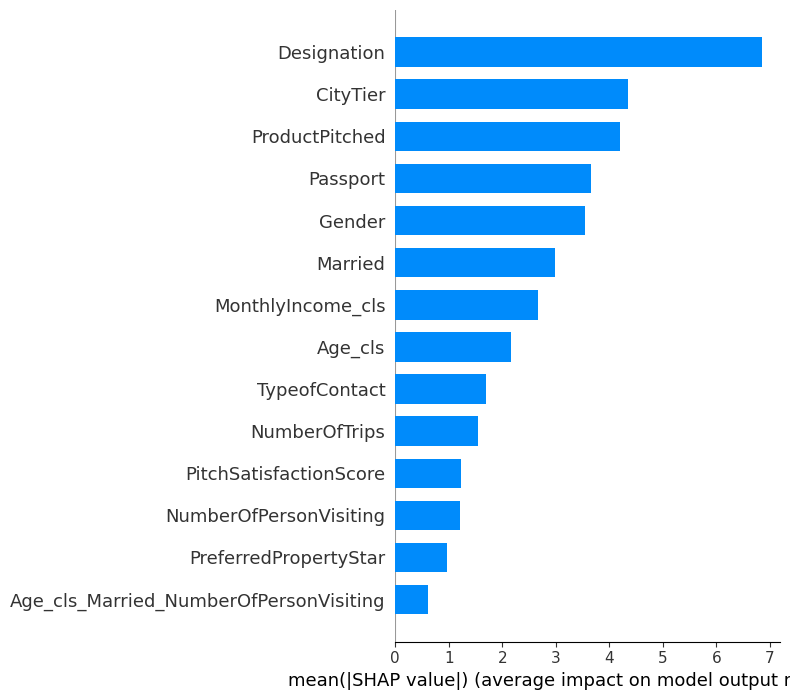

In [141]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()

# 各FOLD、SEEDの和 (相対値なのでこれで良しとする)
shapval = 0
for i in range(3):
  for j in range(5):
    explainer = shap.TreeExplainer(models[i][j])
    shap_values = explainer.shap_values(X)
    shapval = shapval + shap_values

shap.summary_plot(shapval, X,plot_type="bar", max_display=50)